<a href="https://colab.research.google.com/github/acesur/Machine-Learning-/blob/main/03_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Class distribution before filtering:
dx
akiec    142
bcc      142
bkl      142
mel      142
nv       142
vasc     142
df       115
Name: count, dtype: int64

Filtered class distribution:
dx
akiec    142
bcc      142
bkl      142
mel      142
nv       142
vasc     142
df       115
Name: count, dtype: int64

Training set size after SMOTE: 798
Class distribution after SMOTE:
dx
akiec    114
bcc      114
df       114
vasc     114
nv       114
bkl      114
mel      114
Name: count, dtype: int64

Training models...

Evaluating models...

SVM Evaluation:
              precision    recall  f1-score   support

       akiec       0.34      0.39      0.37        28
         bcc       0.18      0.11      0.13        28
         bkl       0.09      0.03      0.05        29
          df       0.30      0.39 

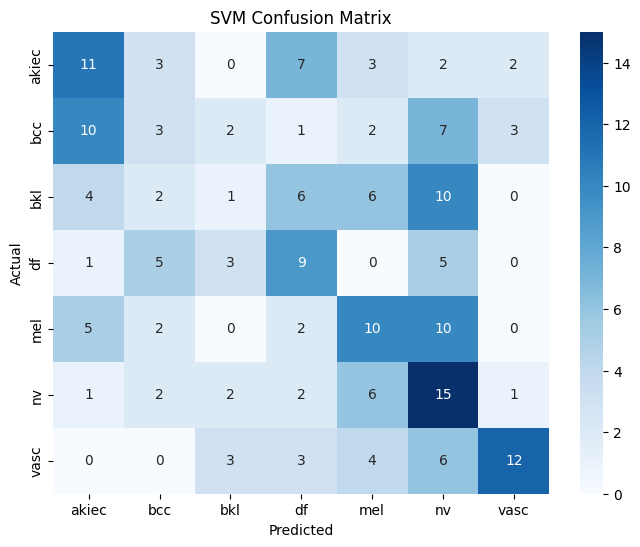


KNN Evaluation:
              precision    recall  f1-score   support

       akiec       0.36      0.43      0.39        28
         bcc       0.23      0.25      0.24        28
         bkl       0.19      0.17      0.18        29
          df       0.15      0.17      0.16        23
         mel       0.48      0.34      0.40        29
          nv       0.23      0.31      0.26        29
        vasc       0.62      0.36      0.45        28

    accuracy                           0.29       194
   macro avg       0.32      0.29      0.30       194
weighted avg       0.33      0.29      0.30       194



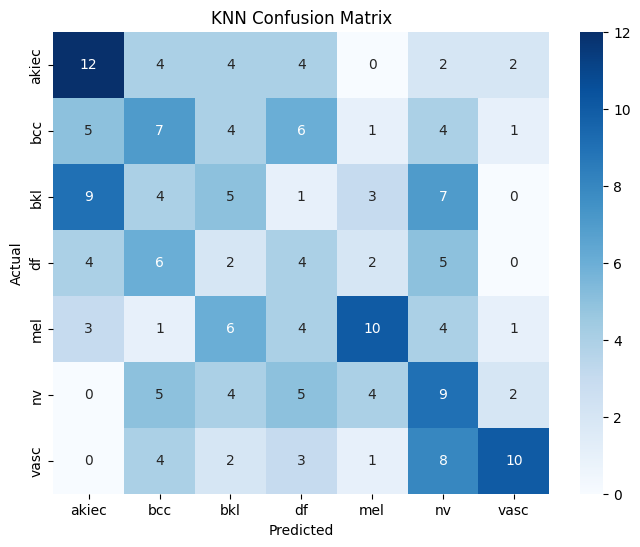


Random Forest Evaluation:
              precision    recall  f1-score   support

       akiec       0.46      0.46      0.46        28
         bcc       0.23      0.21      0.22        28
         bkl       0.21      0.21      0.21        29
          df       0.40      0.35      0.37        23
         mel       0.22      0.24      0.23        29
          nv       0.32      0.45      0.37        29
        vasc       0.74      0.50      0.60        28

    accuracy                           0.35       194
   macro avg       0.37      0.35      0.35       194
weighted avg       0.37      0.35      0.35       194



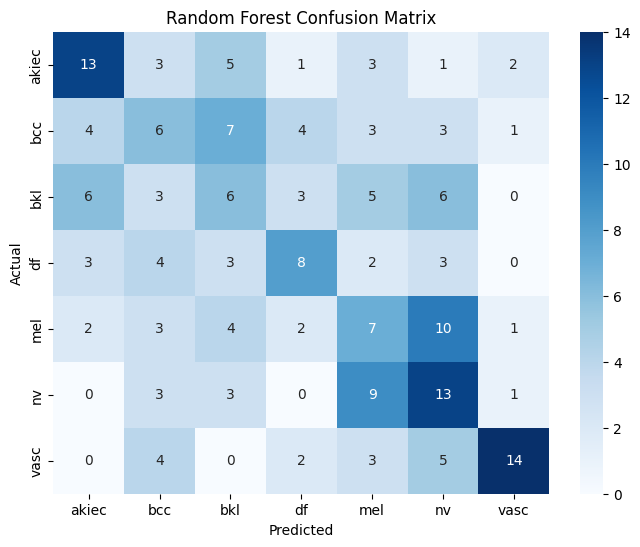


Ensemble Evaluation:
              precision    recall  f1-score   support

       akiec       0.50      0.39      0.44        28
         bcc       0.25      0.18      0.21        28
         bkl       0.20      0.17      0.19        29
          df       0.21      0.26      0.24        23
         mel       0.31      0.38      0.34        29
          nv       0.27      0.41      0.33        29
        vasc       0.65      0.46      0.54        28

    accuracy                           0.32       194
   macro avg       0.34      0.32      0.33       194
weighted avg       0.35      0.32      0.33       194



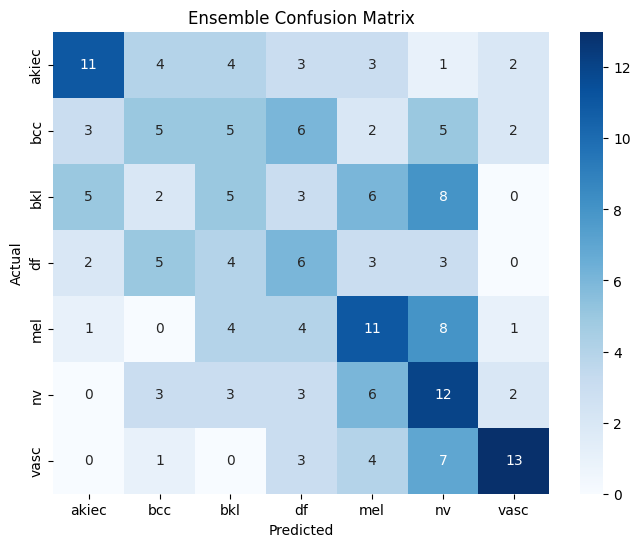

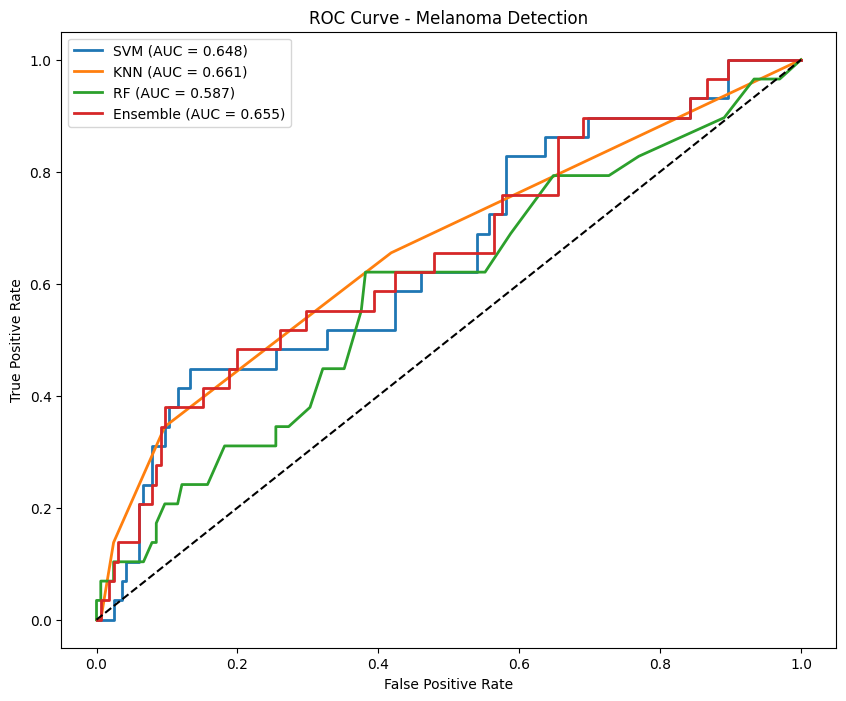

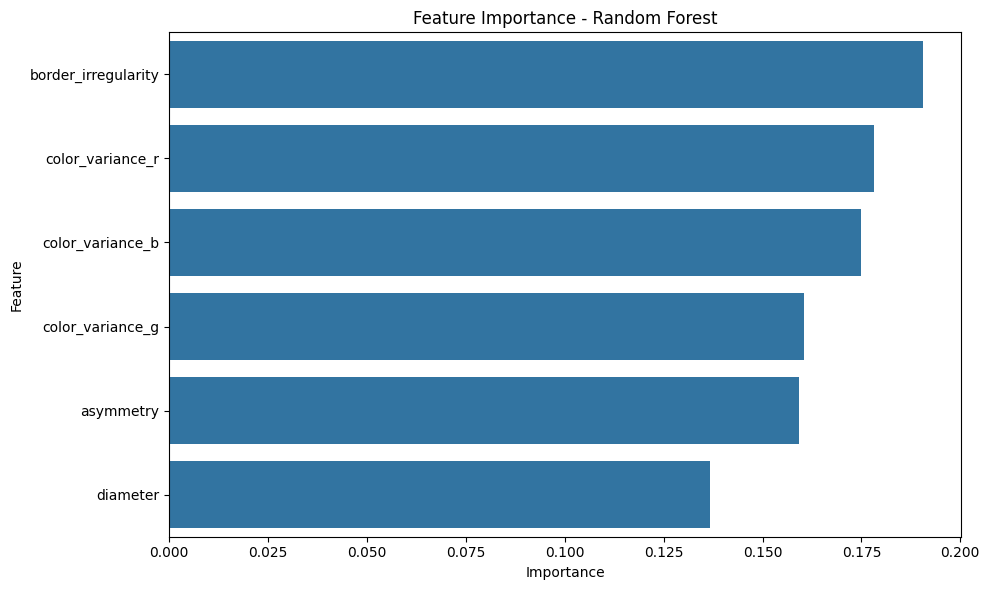

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import kagglehub

# Download dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

from google.colab import drive
drive.mount('/content/drive/')

# Define paths
IMAGES_PATH_PART1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMAGES_PATH_PART2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# Load data
feature_df = pd.read_csv('/content/drive/My Drive/abcd_features.csv')
metadata = pd.read_csv(METADATA_PATH)

# Merge features with metadata
df = feature_df.merge(metadata, on=['image_id', 'dx'], how='inner')
print("Class distribution before filtering:")
print(df['dx'].value_counts())

# Prepare features
non_feature_cols = ['image_id', 'dx', 'lesion_id', 'dx_type', 'age', 'sex', 'localization']
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# Filter out classes with fewer than 2 samples
y = df['dx']
valid_classes = y.value_counts()[y.value_counts() > 1].index
df_filtered = df[df['dx'].isin(valid_classes)]
X = df_filtered[feature_cols].fillna(0)
y = df_filtered['dx']
print("\nFiltered class distribution:")
print(y.value_counts())

# Skip training if only one class
if y.nunique() <= 1:
    print("\nNot enough class variety for training. Please extract more features.")
else:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print("\nTraining set size after SMOTE:", X_train_resampled.shape[0])
    print("Class distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())

    # Train models
    svm = SVC(probability=True, random_state=42)
    knn = KNeighborsClassifier()
    rf = RandomForestClassifier(random_state=42)
    ensemble = VotingClassifier(estimators=[('svm', svm), ('knn', knn), ('rf', rf)], voting='soft')

    print("\nTraining models...")
    for model in [svm, knn, rf, ensemble]:
        model.fit(X_train_resampled, y_train_resampled)

    # Evaluation function
    def evaluate_model(model, X, y, model_name):
        y_pred = model.predict(X)
        print(f"\n{model_name} Evaluation:")
        print(classification_report(y, y_pred))
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Evaluate
    print("\nEvaluating models...")
    evaluate_model(svm, X_test_scaled, y_test, "SVM")
    evaluate_model(knn, X_test_scaled, y_test, "KNN")
    evaluate_model(rf, X_test_scaled, y_test, "Random Forest")
    evaluate_model(ensemble, X_test_scaled, y_test, "Ensemble")

    # ROC for melanoma detection
    if 'mel' in y.unique():
        plt.figure(figsize=(10, 8))
        y_test_binary = (y_test == 'mel').astype(int)
        for model, name in zip([svm, knn, rf, ensemble], ['SVM', 'KNN', 'RF', 'Ensemble']):
            if 'mel' in model.classes_:
                mel_idx = list(model.classes_).index('mel')
                y_score = model.predict_proba(X_test_scaled)
                fpr, tpr, _ = roc_curve(y_test_binary, y_score[:, mel_idx])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Melanoma Detection')
        plt.legend()
        plt.show()
    else:
        print("\nNote: 'mel' class not present. ROC curve not generated.")

    # Feature importance
    if hasattr(rf, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': rf.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance - Random Forest')
        plt.tight_layout()
        plt.show()
